# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn, fx, optim
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus

torch.cuda.empty_cache() # 清空 GPU 缓存

def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                            model.conv1.out_channels, 
                            3, 1, 1)
    model.maxpool = nn.Identity() #nn.Conv2d(64, 64, 1, 1, 1)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

torchvision 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

In [2]:
batch_size = 64
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = create_model()

Files already downloaded and verified
Files already downloaded and verified


```{note}
将第一个 conv 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

查看修改后的模型：

In [3]:
model.conv1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [4]:
model.maxpool

Identity()

打印每层输出尺寸：

In [5]:
for xs, _ in train_iter:
    break

for name, m in model.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (64, 64, 32, 32)
bn1 (64, 64, 32, 32)
relu (64, 64, 32, 32)
maxpool (64, 64, 32, 32)
layer1 (64, 64, 32, 32)
layer2 (64, 128, 16, 16)
layer3 (64, 256, 8, 8)
layer4 (64, 512, 4, 4)
avgpool (64, 512, 1, 1)
fc (64, 10)


微调模型：

In [6]:
def fine_tune(mod, num_epochs,
              train_iter, test_iter,
              devices=try_all_gpus(),
              lr=0.0000142857,
              lr_period=4,
              lr_decay=0.0857142,
              weight_decay=0.00857142,
              momentum=0.857142):
    optimizer = optim.SGD(mod.parameters(),
                          lr=lr,
                          momentum=momentum, 
                          weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=lr_period, 
                                          gamma=lr_decay)
    train(mod, train_iter, test_iter,
          num_epochs, devices,
          optimizer, scheduler)
    return mod

train loss 0.012, train acc 0.997, valid acc 0.924
1380.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


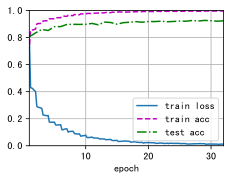

In [7]:
model = create_model()
mod = fine_tune(model, 32,
                train_iter, test_iter, 
                try_all_gpus(),
                lr=0.000142857,
                lr_period=2,
                lr_decay=0.857142,
                weight_decay=0.00857142,
                momentum=0.857142)

torch.save(mod.state_dict(), 
           'models/resnet18_cifar10_batch_size_64.h5')

## 性能度量

In [12]:
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()
        
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        mod(inputs)
        
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        22.88%       2.121ms        99.54%       9.226ms       9.226ms       0.000us         0.00%       2.270ms       2.270ms             1  
                                           aten::conv2d         1.00%      93.000us        43.12%       3.997ms     199.850us       0.000us         0.00%       2.084ms     104.200us            20  
         